In [1]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
import random

plt.rcParams["figure.figsize"] = (12,8)

The SIR model decribes the spread of an infectious disease among a population.

Let $S$ be the number of susceptible people, $I$ be the number of infective people, and $R$ be the number of recovered people.Then the SIR equations read:

$$\color{blue}{\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} & = -\beta SI\\
\frac{\mathrm{d} I}{\mathrm{d} t} & = \beta SI - \gamma I\\
\frac{\mathrm{d} R}{\mathrm{d} t} & = \gamma I\\
\end{aligned}}$$


The basic reproducive rate, defined as $\mathcal{R}_0 \equiv \frac{\beta N}{\gamma}$, is a key parameter that governs the behaviour of the model. Broadly speaking, $\mathcal{R}_0$ is an estimate of the number of individuals that are affected by a primary infective individual. If $\mathcal{R}_0 > 1$, then the infectious disease will develop into an epidemic.



However, the SIR model has its limitations. The SIR model only looks at the statistical expectation of the development of the groups, but each case of infection is probabilistic, and also each case of recovery is probabilistic, there could be unexpected fluctuations that lead to a very different overall picture.

Also, the number of each group is treated as continuous variables in the simple SIR model. But things like 0.7 patient do not make sense. So it would be more realistic to consider the numbers as discrete variables.

Here we present a probabilistic model based on the SIR model. Instead of a set of differential equations, we study the evolution of the groups in terms of a set of difference equations. Let $x[t]$ denote the value of the quantity $x$ at day $t$, then the equations roughly take the following form:

$$\begin{aligned}
S[t+1] & = S[t] - N_\text{exp}[t] + N_\text{sus,i}[t] + N_\text{sus,q}[t]\\
E[t+1] & = E[t] + N_\text{exp}[t] - N_\text{inf}[t] - N_\text{quar,e}[t]\\
I[t+1] & = I[t] + N_\text{inf}[t] - N_\text{quar,i}[t] - N_\text{rec,i}[t] - N_\text{sus,i}[t]\\
Q[t+1] & = Q[t] + N_\text{quar}[t] - N_\text{rec,q}[t] - N_\text{sus,q}[t]\\
R[t+1] & = R[t] + N_\text{rec,i}[t] + N_\text{rec,q}[t] \\
\end{aligned}$$

where the many $N_\text{xxx}$ terms need some further elaboration.

- $N_\text{exp}$: number of newly exposed cases that go into incubation period
- $N_\text{inf}$: number of new cases that develop from incubation period into fully infectious period
- $N_\text{quar}$: number of patients that are targeted and sent into quarantine
- $N_\text{rec}$: number of patients that recover from the disease and become immune to it
- $N_\text{sus}$: number of patients that are no longer positive but may still be vulnerable to secondary infections

To determine $N_\text{xxx}[t]$, we adopt a dice rolling algorithm. For example, for each possible contact between a susceptible person and an infectious patient, we generate a random number. If the number is less than the rate of infection $\beta$, then the susceptible will become infected. A similar approach is used to simulate other $N_\text{xxx}[t]$ terms.

In [2]:
# set the size for the entire population
N = 5000

# simulation time
T = 40

In [8]:
def SEIQR_model(values, params):
    # SEIQR Covid-19 model in terms of difference equations
    # values = [S, E, I, Q, R]
    # params[0] = beta_i (rate of infection due to contact with an exposed patient in incubation period)
    # params[1] = beta_e (rate of infection due to contact with an infectious patient)
    # params[2] = gamma (rate of recovery)
    # params[3] = exposed_to_infected (rate of development from incubation period into infectious state)
    # params[4] = exposed_to_quarantine (rate of targeting the exposed patient)
    # params[5] = infected_to_quarantine (rate of targeting the infected patient)
    # params[6] = secondary_infection (fraction of recovered patients that may be infected for a second time)
    # params[7] = immediate_quarantine (sucess rate of targeting an exposed case in the first place)
    new_exposed = 0
    new_infection = 0
    new_quarantine_s = 0
    new_quarantine_e = 0
    new_quarantine_i = 0
    new_recovery_i = 0
    new_recovery_q = 0
    new_susceptible_i = 0
    new_susceptible_q = 0

    for s in range(values[0]):
        for i in range(values[2]):
            # infection due to contact with an exposed case
            if random.random() < params[1]:
                new_exposed += 1
        for e in range(values[1]):
            # infection due to contact with an infectious case
            if random.random() < params[0]:
                new_exposed += 1
    
    if new_exposed > values[0]:
        new_exposed = values[0]
    
    for ne in range(new_exposed):
        if random.random() < params[7]:
            # newly exposed case is immediately targeted and sent into quarantine
            new_quarantine_s += 1
            new_exposed -= 1
    
    for e in range(values[1]):
        if random.random() < params[4]:
            # exposed case at large is targeted and sent into quarantine
            new_quarantine_e += 1
        elif random.random() < params[3]:
             # exposed case develops into an infectious case
            new_infection += 1

    for i in range(values[2]):
        if random.random() < params[5]:
            # some infectious patients get quarantined
            new_quarantine_i += 1
        elif random.random() < params[2]:
            # infectious patients that are not targeted but recover by themselves
            if random.random() < params[6]:
                # recovered patient may still be infected for the second time
                new_susceptible_i += 1
            else:
                new_recovery_i += 1
    
    for q in range(values[3]):
        if random.random() < params[2]:
            if random.random() < params[6]:
                # recovered patient may still be infected for the second time
                new_susceptible_q += 1
            else:
                new_recovery_q += 1

    S = values[0] - new_exposed + new_susceptible_i + new_susceptible_q - new_quarantine_s
    E = values[1] + new_exposed - new_infection - new_quarantine_e
    I = values[2] + new_infection - new_quarantine_i - new_recovery_i - new_susceptible_i
    Q = values[3] + new_quarantine_s + new_quarantine_e + new_quarantine_i - new_recovery_q - new_susceptible_q
    R = values[4] + new_recovery_i + new_recovery_q
    
    return [S, E, I, Q, R]

In [9]:
def plot_SEIQR(r, N=5000, INIT_VALUES=(4998, 0, 2, 0, 0)):
    S_values = [INIT_VALUES[0]]
    E_values = [INIT_VALUES[1]]
    I_values = [INIT_VALUES[2]]
    Q_values = [INIT_VALUES[3]]
    R_values = [INIT_VALUES[4]]
    
    SEIQR_values = list(INIT_VALUES)
    
    beta_i = r * gamma / N
    beta_e = 0.5 * beta_i
    params = [beta_i, beta_e, gamma, exposed_to_infected, exposed_to_quarantine, infected_to_quarantine, secondary, immediate]
  
    for dummy in range(T):
        SEIQR_values = SEIQR_model(SEIQR_values, params)
        S_values.append(SEIQR_values[0])
        E_values.append(SEIQR_values[1])
        I_values.append(SEIQR_values[2])
        Q_values.append(SEIQR_values[3])
        R_values.append(SEIQR_values[4])
    
    axes = plt.gca()
    axes.title.set_size(25)
    axes.xaxis.label.set_size(12)
    axes.yaxis.label.set_size(12)
    plt.plot(S_values, label = 'Susceptible')
    plt.plot(E_values, label = 'Exposed')
    plt.plot(I_values, label = 'Infective')
    plt.plot(Q_values, label = 'Quarantined')
    plt.plot(R_values, label = 'Recovered')
    plt.title('Covid-19 Model with $\mathcal{R}_0 = $' + str(r))
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Number')
    plt.show()

In [10]:
def SEIQR_T(r, N=5000, INIT_VALUES=(4998, 0, 2, 0, 0)):
    # find the total number of people that get infected during the epidemic at day T
    # r = basic reproductive rate
    # gamma = recovery rate
    SEIQR_values = list(INIT_VALUES)
    
    infected = [sum(INIT_VALUES) - INIT_VALUES[0]]
    
    beta_i = r * gamma / N
    beta_e = 0.5 * beta_i
    params = [beta_i, beta_e, gamma, exposed_to_infected, exposed_to_quarantine, infected_to_quarantine, secondary, immediate]
    
    peak = 0

    for dummy in range(T):
        SEIQR_values = SEIQR_model(SEIQR_values, params)
        if sum(SEIQR_values) - SEIQR_values[0] > peak:
            peak = sum(SEIQR_values) - SEIQR_values[0]
        infected.append(peak)
    
    return infected

In [11]:
def plot_scale(r, n, N=5000, INIT_VALUES=(4998, 0, 2, 0, 0)):
    # run n simulations for a given basic reproductive rate
    axes = plt.gca()
    axes.title.set_size(25)
    axes.xaxis.label.set_size(12)
    axes.yaxis.label.set_size(12)
    plt.ylim(-N*0.05, N*1.05)
    
    for dummy in range(n):
        infected = SEIQR_T(r, N, INIT_VALUES)
        plt.plot(infected)

    plt.title('Total number of people that have been infected ($\mathcal{R}_0 = $' + str(r) + ')')
    plt.xlabel('day')
    plt.ylabel('number of people')
    plt.show()

In [12]:
# spread of the infectious disease under zero control policy
I_0 = 2
E_0 = 0
R_0 = 0
Q_0 = 0
S_0 = N - I_0 - R_0
INIT_VALUES = (S_0, E_0, I_0, Q_0, R_0)

gamma = 0.5
exposed_to_infected = 0.3
exposed_to_quarantine = 0
infected_to_quarantine = 0
secondary = 0.1
immediate = 0

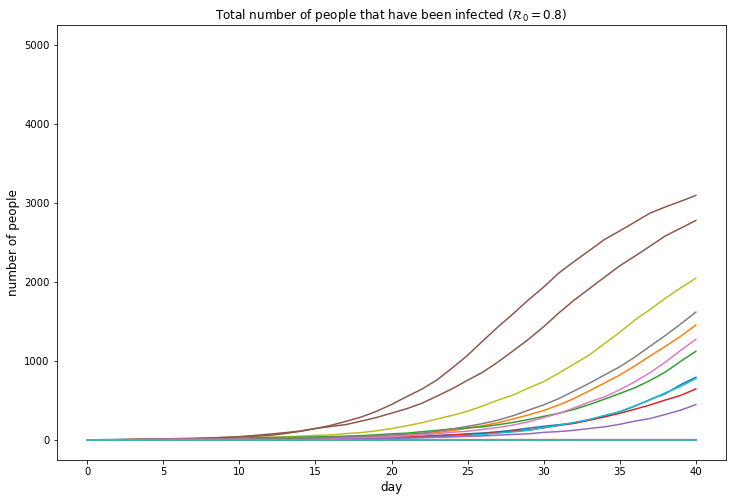

In [14]:
plot_scale(0.8, 20, N, INIT_VALUES)

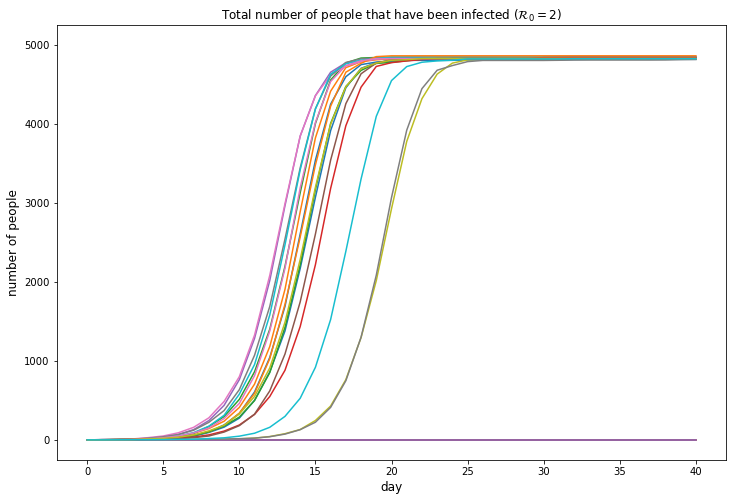

In [15]:
plot_scale(2, 20, N, INIT_VALUES)

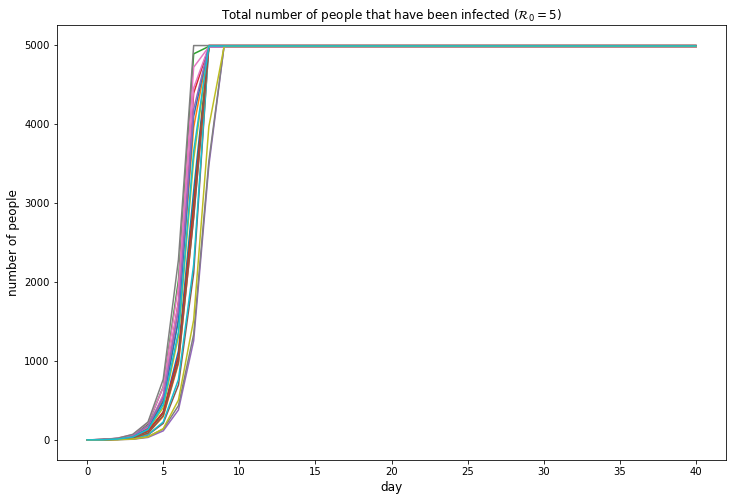

In [17]:
plot_scale(5, 20, N, INIT_VALUES)

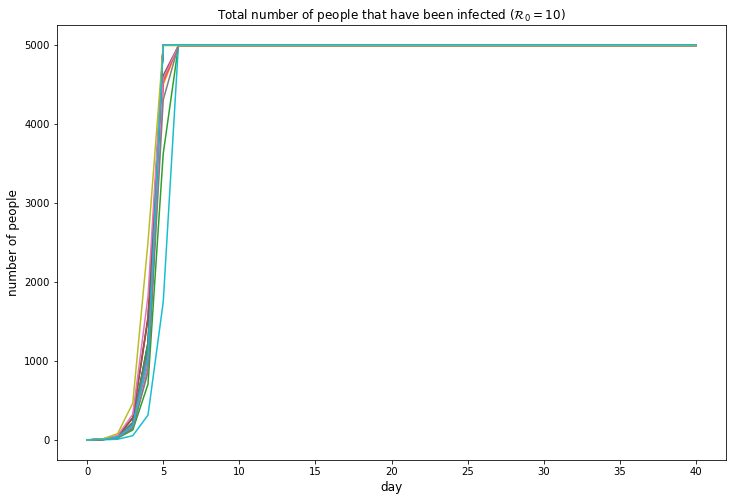

In [16]:
plot_scale(10, 20, N, INIT_VALUES)

In [26]:
# spread of the infectious disease under strict control policy
I_0 = 5
E_0 = 0
R_0 = 0
Q_0 = 0
S_0 = N - I_0 - R_0
INIT_VALUES = (S_0, E_0, I_0, Q_0, R_0)

gamma = 0.5
exposed_to_infected = 0.3
exposed_to_quarantine = 0.9
infected_to_quarantine = 0.95
secondary = 0.1
immediate = 0.75

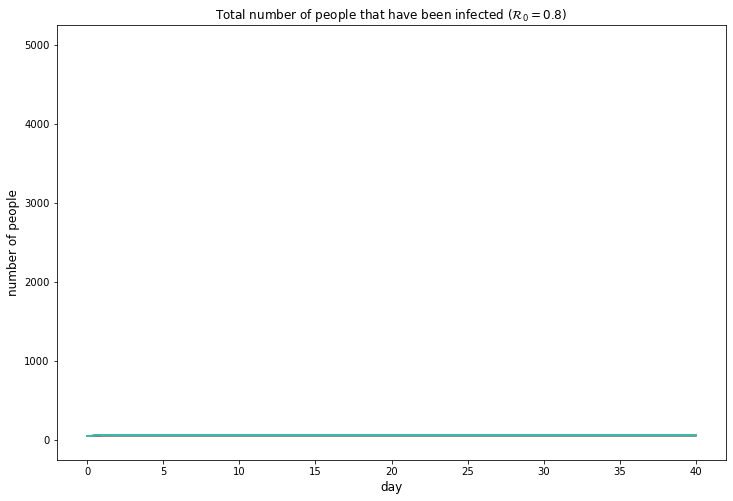

In [24]:
plot_scale(0.8, 20, N, INIT_VALUES)

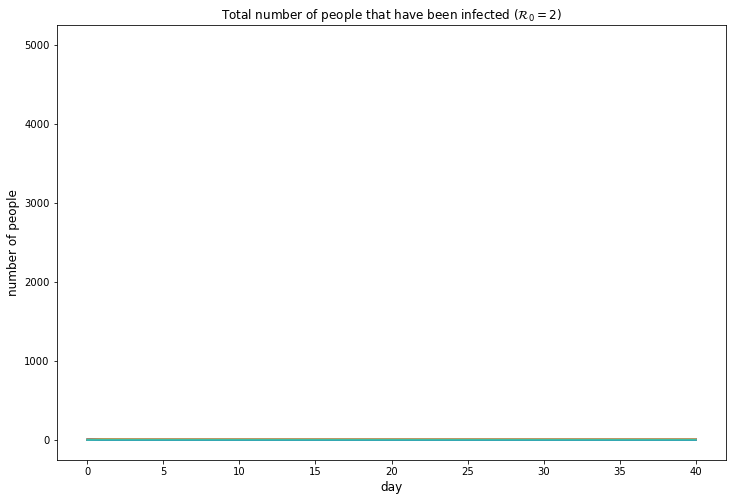

In [19]:
plot_scale(2, 20, N, INIT_VALUES)

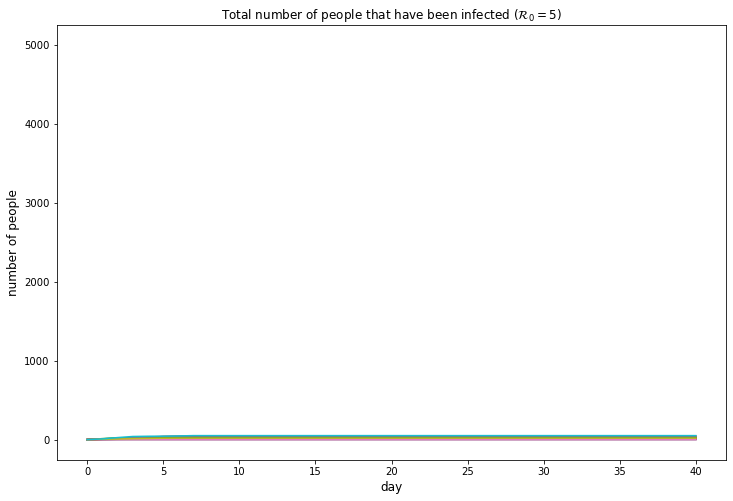

In [20]:
plot_scale(5, 20, N, INIT_VALUES)

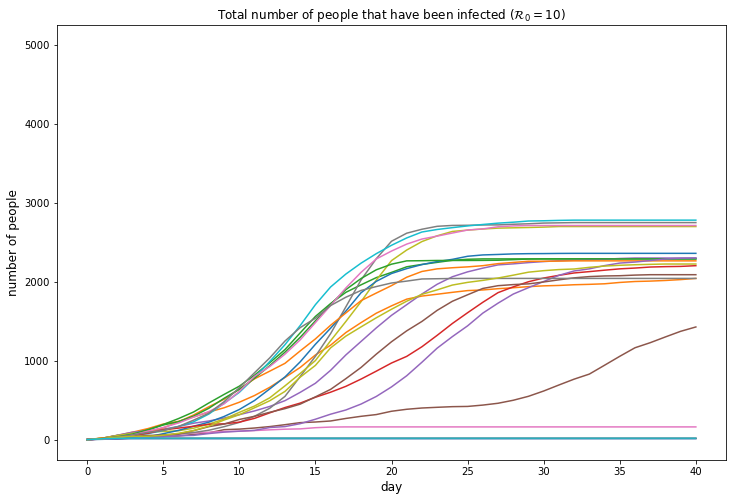

In [30]:
plot_scale(10, 20, N, INIT_VALUES)

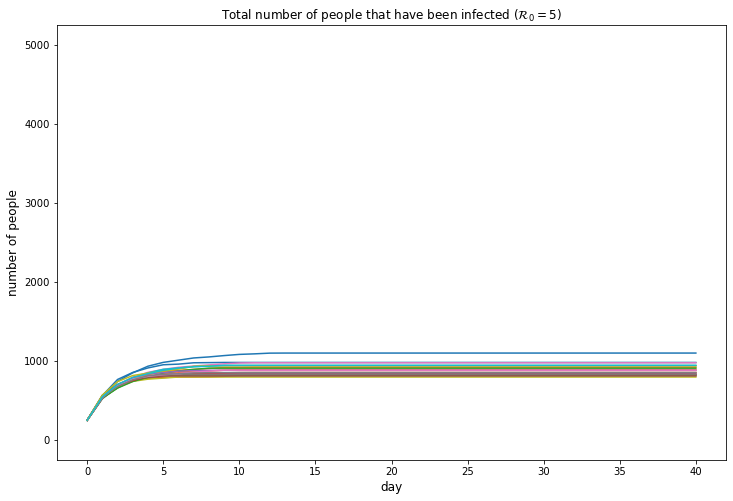

In [22]:
# spread of the infectious disease under strict control policy
I_0 = 250
E_0 = 0
R_0 = 0
Q_0 = 0
S_0 = N - I_0 - R_0
INIT_VALUES = (S_0, E_0, I_0, Q_0, R_0)

gamma = 0.5
exposed_to_infected = 0.3
exposed_to_quarantine = 0.9
infected_to_quarantine = 0.95
secondary = 0.1
immediate = 0.75

plot_scale(5, 20, N, INIT_VALUES)

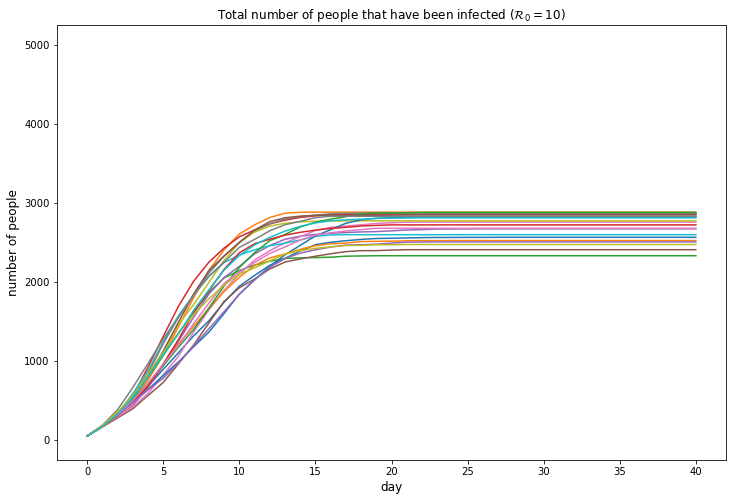

In [23]:
# spread of the infectious disease under strict control policy
I_0 = 50
E_0 = 0
R_0 = 0
Q_0 = 0
S_0 = N - I_0 - R_0
INIT_VALUES = (S_0, E_0, I_0, Q_0, R_0)

gamma = 0.5
exposed_to_infected = 0.3
exposed_to_quarantine = 0.9
infected_to_quarantine = 0.95
secondary = 0.1
immediate = 0.75

plot_scale(10, 20, N, INIT_VALUES)